In [1]:
# --- IMPORTS ---
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define a function which will evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Perform 10-fold cross-validation on the training set (using MAE and R² metrics)
    mae_train = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    r2_train = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

    # Fit on full training set and evaluate on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    # Return results
    return mae_train.mean(), r2_train.mean(), mae_test, r2_test

In [3]:
# Load data
data = pd.read_csv('steel.csv')
X = data.drop("tensile_strength", axis=1)
y = data["tensile_strength"]

# Create train/test split (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Setup 10-fold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

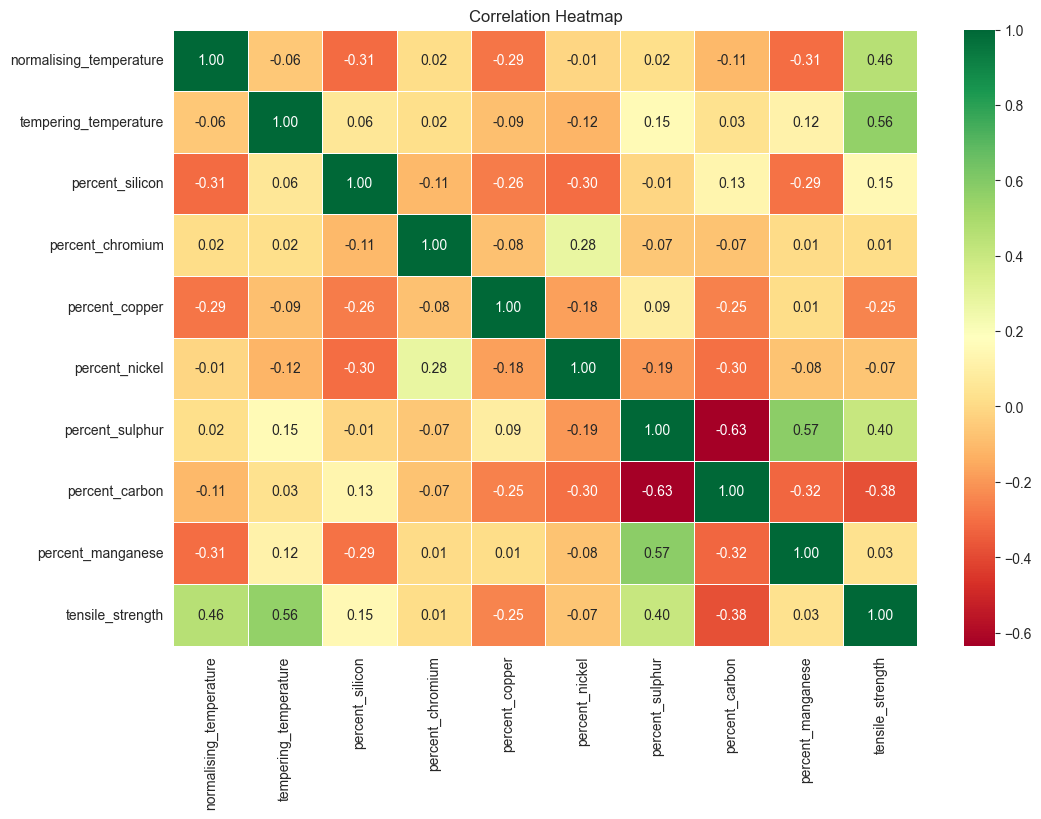

In [4]:
# Calculate and plot the correlation heatmap of steel dataset
plt.figure(figsize=(12, 8))

corr_matrix = data.corr() # Calculate correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [5]:
# Create default model (no hyperparameter tuning)
default_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', KNeighborsRegressor())
])

# Call model evaluation function and extract results into variables
default_mae_train, default_r2_train, default_mae_test, default_r2_test = evaluate_model(
    default_model, X_train, y_train, X_test, y_test
)

# Print out results for untuned model
print("=== DEFAULT K-NN MODEL RESULTS ===")
print(f"Training MAE: {default_mae_train:.3f}, Training R²: {default_r2_train:.3f}")
print(f"Test     MAE: {default_mae_test:.3f}, Test     R²: {default_r2_test:.3f}")

=== DEFAULT K-NN MODEL RESULTS ===
Training MAE: 33.767, Training R²: 0.756
Test     MAE: 38.101, Test     R²: 0.729


In [6]:
# Create grid for chosen hyperparameters
param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 9],
    'regressor__weights': ['uniform', 'distance']
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', KNeighborsRegressor())
])

# Create tuned model #1 (with GridSearchCV for hyperparameter tuning)
# -> This one will be used for the main results and MAE heatmap
tuned_model_mae = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
# Fit the GridSearchCV on the training data
tuned_model_mae.fit(X_train, y_train)

# Create tuned model #2 (with GridSearchCV for hyperparameter tuning)
# -> This one will be used for the R2 heatmap only
tuned_model_r2 = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1
)
# Fit the GridSearchCV on the training data
tuned_model_r2.fit(X_train, y_train)

# Extract the best performing MAE model into variable
best_mae_model = tuned_model_mae.best_estimator_

# Call model evaluation function with best performing MAE model and extract results into variables
tuned_mae_train, tuned_r2_train, tuned_mae_test, tuned_r2_test = evaluate_model(
    best_mae_model, X_train, y_train, X_test, y_test
)

# Print out results for tuned model
print("\n=== TUNED K-NN MODEL RESULTS ===")
print("Best hyperparameters:", tuned_model_mae.best_params_)
print(f"Training MAE: {tuned_mae_train:.3f}, Training R²: {tuned_r2_train:.3f}")
print(f"Test     MAE: {tuned_mae_test:.3f}, Test     R²: {tuned_r2_test:.3f}")


=== TUNED K-NN MODEL RESULTS ===
Best hyperparameters: {'regressor__n_neighbors': 3, 'regressor__weights': 'distance'}
Training MAE: 31.199, Training R²: 0.776
Test     MAE: 34.719, Test     R²: 0.748


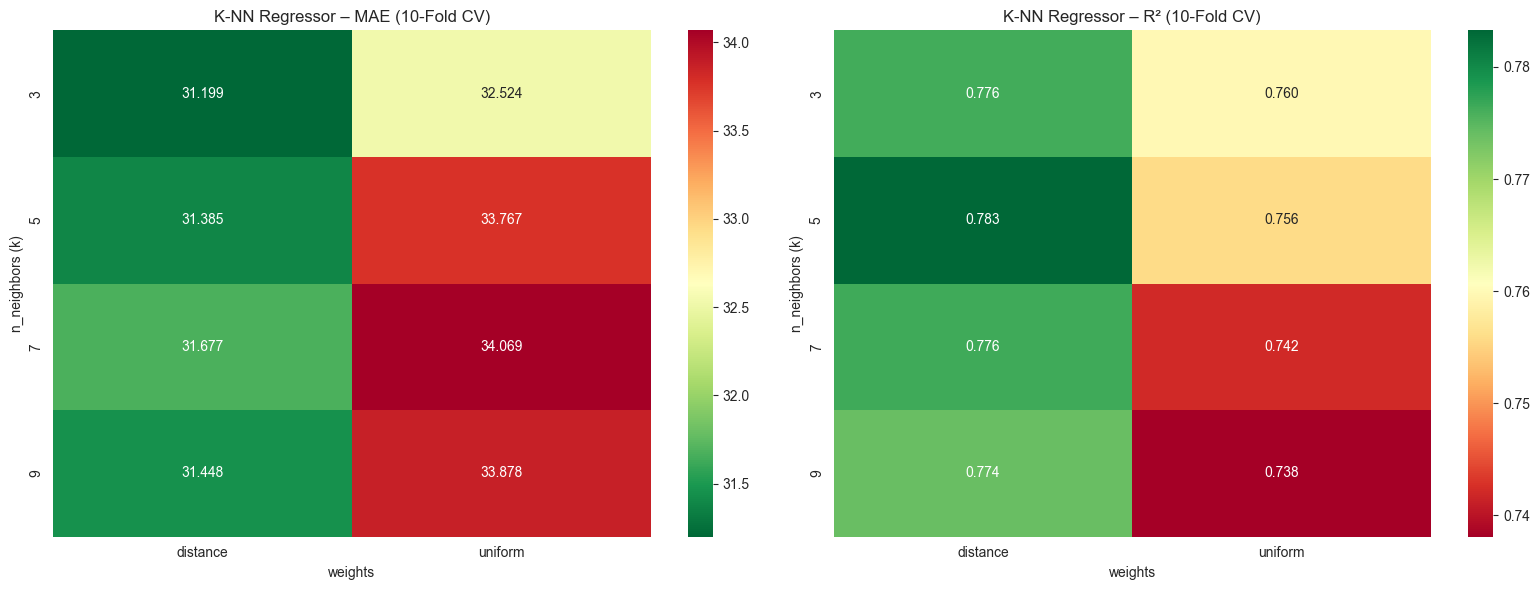

In [7]:
# Create MAE results dataframe
results_mae = pd.DataFrame(tuned_model_mae.cv_results_)

results_mae = results_mae[[
    'param_regressor__n_neighbors',
    'param_regressor__weights',
    'mean_test_score'
]]

# Convert negative MAE to positive
results_mae['MAE'] = -results_mae['mean_test_score']

# Pivot table for heatmap
heatmap_mae = results_mae.pivot(
    index='param_regressor__n_neighbors',
    columns='param_regressor__weights',
    values='MAE'
)

# Create R² results dataframe
results_r2 = pd.DataFrame(tuned_model_r2.cv_results_)

results_r2 = results_r2[[
    'param_regressor__n_neighbors',
    'param_regressor__weights',
    'mean_test_score'
]]

# Pivot table for heatmap
heatmap_r2 = results_r2.pivot(
    index='param_regressor__n_neighbors',
    columns='param_regressor__weights',
    values='mean_test_score'
)

# Plot both heatmaps side-by-side
plt.figure(figsize=(16, 6))

# MAE heatmap
plt.subplot(1, 2, 1)
sns.heatmap(heatmap_mae, annot=True, fmt=".3f", cmap='RdYlGn_r')
plt.title("K-NN Regressor – MAE (10-Fold CV)")
plt.xlabel("weights")
plt.ylabel("n_neighbors (k)")

# R² heatmap
plt.subplot(1, 2, 2)
sns.heatmap(heatmap_r2, annot=True, fmt=".3f", cmap='RdYlGn')
plt.title("K-NN Regressor – R² (10-Fold CV)")
plt.xlabel("weights")
plt.ylabel("n_neighbors (k)")

plt.tight_layout()
plt.show()